# Identify when a record begins based on data availability.

## Code!

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob

%matplotlib inline

### Collect file paths.

In [3]:
obslens_tseries_dir = '/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/OBS_LENS/'

#### Collect GISTEMP 5x5 file paths.

In [4]:
gistemp_5x5_files = glob.glob('%s/GISTEMP_5x5/20240820/xagg/ensembleChunk_5x5_????.nc' % obslens_tseries_dir)
gistemp_5x5_files.sort()

#### Collect HadCRUT5 file paths.

In [5]:
hadcrut5_files = glob.glob('%s/HadCRUT5/20240820/xagg/HadCRUT.5.0.2.0.analysis.anomalies.*.nc' % obslens_tseries_dir)
hadcrut5_files = [i for i in hadcrut5_files if "Trends" not in i]
hadcrut5_files.sort()

#### Collect DCENT unfilled file paths.

In [6]:
dcent_unfilled_files = glob.glob('%s/DCENT/20240901/xagg/DCENT_ensemble_1850_2023_member_???.nc' % obslens_tseries_dir)
dcent_unfilled_files = [i for i in dcent_unfilled_files if "Trends" not in i]
dcent_unfilled_files.sort()

## Identify a start year based on data availability

In [7]:
# test_gistemp = xr.open_dataset(gistemp_5x5_files[0]).sel(time=slice(None, "2020"))
# test_hadcrut = xr.open_dataset(hadcrut5_files[0]).sel(time=slice(None, "2020"))

Less conservative annual averaging.  
To quote Lenssen et al. (2019) "To have coverage for a year it must have coverage for at least three seasons, which requires at least 2 months in the season.”

In [8]:
def annual_data(
    ds: xr.DataArray,
    season_threshold: int=3,
    intraseason_threshold: int=2,
):
    """
    Mask data if any season is missing more than one month.
    To quote Lenssen et al. (2019) "To have coverage for a year it must have coverage for at least 
    three seasons, which requires at least 2 months in the season.”

    Args:
        ds (xr.DataArray): Input data

    Returns:
        ds (xr.DataArray): Mask of availability!
    """
    availability = ds["time.season"].where(~np.isnan(ds))
    
    complete_seasons = 0
    seasons = ["DJF", "MAM", "JJA", "SON"]
    for _szn in seasons:
        complete_seasons += ((availability == _szn).sum(dim="time") >= intraseason_threshold)
        
    return complete_seasons >= season_threshold

The simplest approach excludes too much data!

In [9]:
def startyear1(
    data_annual: xr.DataArray,
):
    """_summary_

    Args:
        data_annual (xr.DataArray): Actual data in an annual mean resolution. Remember use skipna=False!

    Returns:
        startyear_full: xarray DataArray with the start year for each region.
    """
    # Compute the last nan year and step one year forward.
    startyear = data_annual["year"].where(np.isnan(data_annual)).max(dim="year") + 1

    complete_tseries = ~np.isnan(data_annual).any(dim="year") # Identify regions without any nans
    absent_tseries = (startyear == data_annual.year[-1]) | (startyear == data_annual.year[-1] + 1) # Identify regions with all nans

    # Set the complete years to the record start year
    startyear_full = xr.where(complete_tseries, data_annual.year[0], startyear)
    # Set the years with consistent missing data to no start year
    startyear_full = xr.where(absent_tseries, np.nan, startyear_full)
    
    return startyear_full

In [10]:
# # Simplest approach, startdate is after the last nan
# # Add one because this was the last nan, not the first actual number
# startyear = test_annual["year"].where(np.isnan(test_annual)).max(dim="year") + 1

# complete_tseries = ~np.isnan(test_annual).any(dim="year") # Regions without any nans
# absent_tseries = (startyear == test_annual.year[-1]) | (startyear == test_annual.year[-1] + 1) # Regions with all nans

# # Set the complete years to the record start year
# startyear_full = xr.where(complete_tseries, test_annual.year[0], startyear)
# # Set the years with consistent missing data to no start year
# startyear_full = xr.where(absent_tseries, np.nan, startyear_full)

# # When the record goes into 2023 the missing regions are 21, 22, 40, and 41. All characterized by missing data recently.
# # This is honestly why we end in 2020 because the recent missing data probably just means
# # that it hasn't been assimilated or publicly.

# # When the record ends in 2020, Region 11 in S. America goes to a nan also because of recent missing data.

Instead, ask for good data during the start year and >= 80% coverage during all following 10-year periods. This seems to work quite well.

In [11]:
# # Second approach, want a non-nan and 80% availability in the next decade
# not_nans = ~np.isnan(test_annual)

# # Center = False labels at the end of the window when I want the start. i.e. 1920 means the 1911-1920 mean
# # Does any 10-year period have less than 80% availability?
# window = 10
# fraction_avail = 0.8
# available_frac = ~np.isnan(
#     test_annual.rolling(
#         dim={"year": window},
#         center=False, 
#         min_periods=window * fraction_avail,
#     ).mean(),
# )

# # Compute the first year when all following 10-year segments have >80% availability
# # Add 1 to go the first year when True, subtract 9 because the window is labelled by the end year
# available_frac_forward = available_frac["year"].where(~available_frac).max(dim="year") + 1 - 9
# available_frac_forwardall = test_annual["year"] >= available_frac_forward # Fill forward

# # Startyear requires both!
# startyear2 = test_annual["year"].where(not_nans & available_frac_forwardall).min(dim="year")


In [12]:
def startyear2(
    data_annual: xr.DataArray,
    window: int = 10,
    fraction: float = 0.7,
):
    """
    This function identifies start years using two conditions:
        1. The data for that year is not a nan.
        2. All following windows of length "window" have at least
        "fraction" availability.

    Args:
        data_annual (xr.DataArray): Actual data in an annual mean resolution. Remember use skipna=False!
        window (int, optional): Window length. Defaults to 10.
        fraction (float, optional): Availability fraction cutoff. Defaults to 0.7.

    Returns:
        startyear: xarray DataArray with the start year for each region.
    """
    # Simple mask for none nans
    not_nans = ~np.isnan(data_annual)

    # Center = False labels at the end of the window when I want the start. i.e. 1920 means the 1911-1920 mean
    # Does any 10-year period have less than 80% availability?
    available_frac = ~np.isnan(
        data_annual.rolling(
            dim={"year": window},
            center=False, 
            min_periods=window * fraction,
        ).mean(),
    )

    # Compute the first year when all following 10-year segments have >80% availability
    # Add 1 to go the first year when True, but subtract 9 because the window is labelled
    # by the end year (i.e. to shift the label from 1920 to 1911 for a 1911-1920 window)
    available_frac_forward = available_frac["year"].where(~available_frac).max(dim="year") + 2 - window
    available_frac_forwardall = data_annual["year"] >= available_frac_forward # Fill forward

    # Startyear is the first year when both conditions are met.
    startyear = data_annual["year"].where(not_nans & available_frac_forwardall).min(dim="year")
    
    return startyear

In [13]:
def startyear3(
    mask_annual: xr.DataArray,
    window: int = 10,
    fraction: float = 0.7,
):
    """
    This function identifies start years from a Boolean mask indicating 
    annual data availability input using two conditions:
        1. The data for that year is present.
        2. All following windows of length "window" have at least
        "fraction" availability.

    Args:
        data_annual (xr.DataArray): Boolean mask in an annual mean resolution. i.e. Produced by annual_mask()
        window (int, optional): Window length. Defaults to 10.
        fraction (float, optional): Availability fraction cutoff. Defaults to 0.7.

    Returns:
        startyear: xarray DataArray with the start year for each region.
    """

    # Center = False labels at the end of the window when I want the start. i.e. 1920 means the 1911-1920 mean
    # e.g. Does any 10-year period have less than 80% availability?
    available_frac = mask_annual.rolling(
        dim={"year": window},
        center=False, 
    ).sum() >= window * fraction

    # Compute the first year when all following 10-year segments have >80% availability
    # Add 1 to go the first year when True, but subtract (window - 1) because the window is labelled
    # by the end year (i.e. to shift the label from 1920 to 1911 for a 1911-1920 10-year window)
    available_frac_forward = available_frac["year"].where(~available_frac).max(dim="year") - window + 2
    available_frac_forwardall = mask_annual["year"] >= available_frac_forward # Fill forward

    # Startyear is the first year when both conditions are met.
    startyear = mask_annual["year"].where(mask_annual & available_frac_forwardall).min(dim="year")
    
    return startyear

In [14]:
def startyear_gaplength(
    mask_annual: xr.DataArray,
    maxgap: int = 5,
    fraction: float = 0.6666,
    fillvalue: int = 2100,
):
    """
    This function identifies start years from a Boolean mask indicating 
    annual data availability input using two conditions:
        1. The data is present for a duration of at least "maxgap" starting in that year.
        2. There are no data gaps exceeding "maxgap"

    Args:
        data_annual (xr.DataArray): Boolean mask in an annual mean resolution. i.e. Produced by annual_mask()
        maxgap (int, optional): Gap length length. Defaults to 5.
        fillvalue (int, optional): Real values to fill when a startdate is not detected. Defaults to 2100.

    Returns:
        startyear: xarray DataArray with the start year for each region.
    """

    # Center = False labels at the end of the window when I want the start. i.e. 1920 means the 1911-1920 mean
    # True if year represents the beginning of a window with coverage >= fraction.
    no_gap = (mask_annual.rolling(
        dim={"year": maxgap},
        center=False,
    ).sum() >= maxgap * fraction).shift(year=1 - maxgap, fill_value=True)
    
    # print("no_gap: ")
    # print(no_gap)
    
    # True if year represents the end of a missing window of length "maxgap"
    gap = (mask_annual.rolling(
        dim={"year": maxgap},
        center=False,
    ).sum() == 0)    

    # print("gap: ")
    # print(gap)
    
    # Compute the earliest year after all gaps. 
    # Add 1 to move to no gap but subtract (maxgap - 1) to correct coordinate labelling
    
    # Last year of all 5-year gaps
    lastgap_year = gap["year"].where(gap).max(dim="year")
    # If no gaps then set as the year before the start year
    lastgap_year = lastgap_year.where(~np.isnan(lastgap_year), mask_annual["year"][0] - 1)
    nogap_forwardall = mask_annual["year"] > lastgap_year # True after the last 5-year gap
    
    # print("lastgap_year: ", lastgap_year)
    # print("nogap_forwardall: ", nogap_forwardall)
    # print("no_gap: ", no_gap)

    # Startyear is the first year when both conditions are met.
    all_conditions = nogap_forwardall & no_gap & mask_annual
    startyear = mask_annual["year"].where(all_conditions).min(dim="year")

    # print("nogap_forwardall & no_gap: ", nogap_forwardall & no_gap)
    # print("startyear: ", startyear)
    
    startyear = startyear.where(all_conditions.any(dim="year"), fillvalue) # Fill nans if no available gaps

    return startyear

In [15]:
def startyear_running_availability(
    mask_annual: xr.DataArray,
    windows: list = [5, 10, 20, 40],
    fraction: float = 0.6666,
    fillvalue: int = 2100,
):
    """
    This function identifies start years from a Boolean mask indicating 
    annual data availability input using two conditions:
        1. The data is present during the startyear.
        2. There is at least "fraction" data availability for windows of length "windows".

    Args:
        data_annual (xr.DataArray): Boolean mask in an annual mean resolution. i.e. Produced by annual_mask()
        windows (list, optional): Window lengths to test.
        fraction (float, optional): Fraction of data availability needed for a window to be considered available.
        fillvalue (int, optional): Real values to fill when a startdate is not detected. Defaults to 2100.

    Returns:
        startyear: xarray DataArray with the start year for each region.
    """

    # Center = False labels at the end of the window when I want the start. i.e. 1920 means the 1911-1920 mean
    # True if year represents the beginning of a window with coverage >= fraction.
    cumulative_avail_mask = mask_annual
    for _length in windows:
        _avail_mask = (mask_annual.rolling(
                dim={"year": _length},
                center=False,
            ).sum() >= _length * fraction
        ).shift(year=1 - _length, fill_value=True) # Shift so labelled by start and fill nans when incomplete
        cumulative_avail_mask = cumulative_avail_mask & _avail_mask

    startyear = mask_annual["year"].where(cumulative_avail_mask).min(dim="year")
    startyear = startyear.where(cumulative_avail_mask.any(dim="year"), fillvalue) # Fill nans if no available gaps

    return startyear

In [16]:
gistemp_tas_var = "tas"
hadcrut5_tas_var = "tas"
_gistemp_ds = xr.open_dataset(gistemp_5x5_files[0])[gistemp_tas_var]
_hadcrut5_ds = xr.open_dataset(hadcrut5_files[0])[hadcrut5_tas_var]

# Create mask of available by Nathan's GISTEMP standard but 4 seasons.
# Require 4 seasons because trends may be influenced by missing seasons.
_availability_mask_gistemp = _gistemp_ds.groupby("time.year").map(annual_data, season_threshold=4)
_availability_mask_hadcrut5 = _hadcrut5_ds.groupby("time.year").map(annual_data, season_threshold=4)

In [17]:
# teststartyear_gistemp = startyear_gaplength(_availability_mask_gistemp)
# teststartyear_hadcrut5 = startyear_gaplength(_availability_mask_hadcrut5)

teststartyear_gistemp = startyear_running_availability(_availability_mask_gistemp)
teststartyear_hadcrut5 = startyear_running_availability(_availability_mask_hadcrut5)

In [32]:
_availability_mask_hadcrut5.sel(RegionIndex=7)

<xarray.DataArray 'season' (realization: 1, year: 175)> Size: 175B
array([[False, False, False,  True,  True,  True,  True,  True,  True,
         True, False, False, False, False, False, False, False,  True,
         True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False]])
Coordinates:
    RegionIndex   int64 8B 7
    Continent     <U15 60B 'CENTRAL-AMERICA'
    Type          <U10 40B 'Land'
    RegionName    <U25 100B 'S.Central-America'
    RegionAbbrev  <U4 16B 'SCA'
  * realization   (realization) int64 8B 1
  * year          (year) int64 1kB 1850 1851 1852 1853 ... 2021 2022 2023 2024

In [28]:
teststartyear_hadcrut5 #.sel(RegionIndex=49)

<xarray.DataArray 'year' (realization: 1, RegionIndex: 58)> Size: 464B
array([[1901., 1899., 1913., 1853., 1850., 1850., 1870., 1884., 1883.,
        1891., 1894., 1894., 1901., 1873., 1856., 1870., 1903., 1850.,
        1850., 1850., 1889., 1886., 1901., 1901., 1895., 1899., 1892.,
        1881., 1901., 1850., 1858., 1890., 1875., 1875., 1875., 1875.,
        1878., 1875., 1881., 1901., 1879., 1858., 1877., 1879., 1957.,
        2100., 1933., 1908., 1923., 1964., 1878., 1884., 1869., 1876.,
        1876., 1879., 1854., 1985.]])
Coordinates:
  * RegionIndex   (RegionIndex) int64 464B 0 1 2 3 4 5 6 ... 52 53 54 55 56 57
    Continent     (RegionIndex) <U15 3kB 'POLAR' 'NORTH-AMERICA' ... 'SOUTHERN'
    Type          (RegionIndex) <U10 2kB 'Land' 'Land' ... 'Ocean' 'Ocean'
    RegionName    (RegionIndex) <U25 6kB 'Greenland/Iceland' ... 'Southern-Oc...
    RegionAbbrev  (RegionIndex) <U4 928B 'GIC' 'NWN' 'NEN' ... 'EIO' 'SIO' 'SOO'
  * realization   (realization) int64 8B 1

In [18]:
teststartyear_gistemp

<xarray.DataArray 'year' (realization: 1, RegionIndex: 58)> Size: 464B
array([[1880., 1900., 1880., 1880., 1880., 1880., 1880., 1880., 1880.,
        1900., 1900., 1900., 1900., 1880., 1880., 1880., 1880., 1880.,
        1880., 1880., 1900., 1900., 1900., 1900., 1900., 1900., 1900.,
        1880., 1890., 1880., 1880., 1890., 1880., 1880., 1880., 1880.,
        1880., 1880., 1880., 1880., 1880., 1880., 1880., 1880., 1960.,
        1960., 1930., 1880., 1880., 1880., 1880., 1880., 1880., 1880.,
        1880., 1880., 1880., 2100.]])
Coordinates:
  * RegionIndex   (RegionIndex) int64 464B 0 1 2 3 4 5 6 ... 52 53 54 55 56 57
    Continent     (RegionIndex) <U15 3kB 'POLAR' 'NORTH-AMERICA' ... 'SOUTHERN'
    Type          (RegionIndex) <U10 2kB 'Land' 'Land' ... 'Ocean' 'Ocean'
    RegionName    (RegionIndex) <U25 6kB 'Greenland/Iceland' ... 'Southern-Oc...
    RegionAbbrev  (RegionIndex) <U4 928B 'GIC' 'NWN' 'NEN' ... 'EIO' 'SIO' 'SOO'
  * realization   (realization) int64 8B 1

In [85]:
_availability_mask_hadcrut5.sel(RegionIndex=56) #, year=1963)

<xarray.DataArray 'season' (realization: 1, year: 175)> Size: 175B
array([[False, False, False, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False, False,  True,
         True,  True,  True,  True, False, False,  True, False,  True,
         True, False, False, False, False,  True,  True,  True,  True,
         True,  True,  True,  True, False, False, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
        False, False, False, False, False, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False]])
Coordinates:
    RegionIndex   int64 8B 56
    Continent     <U15 60B 'INDIAN'
    Type          <U10 40B 'Ocean'
    RegionName    <U25 100B 'S.Indic-Ocean'
    RegionAbbrev  <U4 16B 'SIO'
  * realization   (realization) int64 8B 1
  * year          (year) int64 1kB 1850 1851 1852 1853 ... 2021 2022 2023 2024

In [86]:
teststartyear_hadcrut5.sel(RegionIndex=56)

<xarray.DataArray 'year' (realization: 1)> Size: 8B
array([1946.])
Coordinates:
    RegionIndex   int64 8B 56
    Continent     <U15 60B 'INDIAN'
    Type          <U10 40B 'Ocean'
    RegionName    <U25 100B 'S.Indic-Ocean'
    RegionAbbrev  <U4 16B 'SIO'
  * realization   (realization) int64 8B 1

In [61]:
teststartyear_gistemp

<xarray.DataArray 'year' (realization: 1, RegionIndex: 58)> Size: 464B
array([[1880., 1900., 1880., 1880., 1880., 1880., 1880., 1880., 1880.,
        1900., 1900., 1900., 1900., 1880., 1880., 1880., 1880., 1880.,
        1880., 1880., 1900., 1900., 1900., 1900., 1900., 1900., 1900.,
        1880., 1890., 1880., 1880., 1890., 1880., 1880., 1880., 1880.,
        1880., 1880., 1880., 1880., 1880., 1880., 1880., 1880., 1960.,
        1960., 1930., 1880., 1880., 1880., 1880., 1880., 1880., 1880.,
        1880., 1880., 1880., 2100.]])
Coordinates:
  * RegionIndex   (RegionIndex) int64 464B 0 1 2 3 4 5 6 ... 52 53 54 55 56 57
    Continent     (RegionIndex) <U15 3kB 'POLAR' 'NORTH-AMERICA' ... 'SOUTHERN'
    Type          (RegionIndex) <U10 2kB 'Land' 'Land' ... 'Ocean' 'Ocean'
    RegionName    (RegionIndex) <U25 6kB 'Greenland/Iceland' ... 'Southern-Oc...
    RegionAbbrev  (RegionIndex) <U4 928B 'GIC' 'NWN' 'NEN' ... 'EIO' 'SIO' 'SOO'
  * realization   (realization) int64 8B 1

In [19]:
_availability_mask.sel(RegionIndex=44)

<xarray.DataArray 'season' (realization: 1, year: 141)> Size: 141B
array([[False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True]])
Coordinates:
    RegionIndex   int64 8B 44
    Continent     <U15 60B 'POLAR'
    Type          <U10 40B 'Land'
    RegionName    <U25 100B 'E.Antarctica'
    RegionAbbrev  <U4 16B 'EAN'
  * realization   (realization) int64 8B 1
  * year          (year) int64 1kB 1880 1881 1882 1883 ... 2017 2018 2019 2020

In [25]:
mask_annual = _availability_mask.sel(RegionIndex=44)
maxgap = 5

gap = (mask_annual.rolling(
    dim={"year": maxgap},
    center=False,
    # fillvalue=False, # Fill incomplete windows with True.
).sum() == 0)   

In [26]:
gap

<xarray.DataArray 'season' (realization: 1, year: 141)> Size: 141B
array([[False, False, False, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False]])
Coordinates:
    RegionIndex   int64 8B 44
    Continent     <U15 60B 'POLAR'
    Type          <U10 40B 'Land'
    RegionName    <U25 100B 'E.Antarctica'
    RegionAbbrev  <U4 16B 'EAN'
  * realization   (realization) int64 8B 1
  * year          (year) int64 1kB 1880 1881 1882 1883 ... 2017 2018 2019 2020

In [ ]:
_availability_mask

<xarray.DataArray 'season' (realization: 1, RegionIndex: 58, year: 141)> Size: 8kB
array([[[ True,  True,  True, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [False, False, False, ..., False, False, False]]])
Coordinates:
  * RegionIndex   (RegionIndex) int64 464B 0 1 2 3 4 5 6 ... 52 53 54 55 56 57
    Continent     (RegionIndex) <U15 3kB 'POLAR' 'NORTH-AMERICA' ... 'SOUTHERN'
    Type          (RegionIndex) <U10 2kB 'Land' 'Land' ... 'Ocean' 'Ocean'
    RegionName    (RegionIndex) <U25 6kB 'Greenland/Iceland' ... 'Southern-Oc...
    RegionAbbrev  (RegionIndex) <U4 928B 'GIC' 'NWN' 'NEN' ... 'EIO' 'SIO' 'SOO'
  * realization   (realization) int64 8B 1
  * year          (year) int64 1kB 1880 1881 1882 1883 ... 2017 2018 2019 2020

In [37]:
teststartyear = startyear_gaplength(_availability_mask.sel(RegionIndex=44))

lastgap_year:  <xarray.DataArray 'year' (realization: 1)> Size: 8B
array([1959.])
Coordinates:
    RegionIndex   int64 8B 44
    Continent     <U15 60B 'POLAR'
    Type          <U10 40B 'Land'
    RegionName    <U25 100B 'E.Antarctica'
    RegionAbbrev  <U4 16B 'EAN'
  * realization   (realization) int64 8B 1
nogap_forwardall:  <xarray.DataArray 'year' (year: 141, realization: 1)> Size: 141B
array([[False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
...
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [

In [38]:
teststartyear

<xarray.DataArray 'year' (realization: 1)> Size: 8B
array([1960.])
Coordinates:
    RegionIndex   int64 8B 44
    Continent     <U15 60B 'POLAR'
    Type          <U10 40B 'Land'
    RegionName    <U25 100B 'E.Antarctica'
    RegionAbbrev  <U4 16B 'EAN'
  * realization   (realization) int64 8B 1

In [246]:
_availability_mask.sel(RegionIndex=44, year=slice("1950", None))

<xarray.DataArray 'season' (realization: 1, year: 71)> Size: 71B
array([[False, False, False, False, False, False, False, False, False,
        False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True]])
Coordinates:
    RegionIndex   int64 8B 44
    Continent     <U15 60B 'POLAR'
    Type          <U10 40B 'Land'
    RegionName    <U25 100B 'E.Antarctica'
    RegionAbbrev  <U4 16B 'EAN'
  * realization   (realization) int64 8B 1
  * year          (year) int64 568B 1950 1951 1952 1953 ... 2017 2018 2019 2020

In [245]:
teststartyear

<xarray.DataArray 'year' (realization: 1)> Size: 8B
array([1960.])
Coordinates:
    RegionIndex   int64 8B 44
    Continent     <U15 60B 'POLAR'
    Type          <U10 40B 'Land'
    RegionName    <U25 100B 'E.Antarctica'
    RegionAbbrev  <U4 16B 'EAN'
  * realization   (realization) int64 8B 1

In [220]:
test_gap = (_availability_mask.rolling(
        dim={"year": 5},
        center=False, 
).sum() == 0)

In [226]:
nogap_forward = test_gap["year"].where(test_gap).max(dim="year") - 5 + 2
nogap_forwardall = _availability_mask["year"] >= nogap_forward # Fill forward

In [230]:
nogap_forwardall.sel(RegionIndex=44, year=slice(1950,None))

<xarray.DataArray 'year' (year: 71, realization: 1)> Size: 71B
array([[False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
...
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True]])
Coordinates:
  * year          (year) int64 568B 1950 1951 1952 1953 ... 2017 2018 2019 2020
    RegionIndex   int64 8B 44
    Continent     <U15 60B 'POLAR'
    Type          <U10 40B 'Land'
    RegionName    <U25 100B 'E.Antarctica'
    RegionAbbrev  <U4 16B 'EAN'
  * realization   (realization) int64 8B 1

In [225]:
nogap_forward.sel(RegionIndex=44)

<xarray.DataArray 'year' (realization: 1)> Size: 8B
array([1956.])
Coordinates:
    RegionIndex   int64 8B 44
    Continent     <U15 60B 'POLAR'
    Type          <U10 40B 'Land'
    RegionName    <U25 100B 'E.Antarctica'
    RegionAbbrev  <U4 16B 'EAN'
  * realization   (realization) int64 8B 1

In [223]:
test_gap.sel(RegionIndex=44)

<xarray.DataArray 'season' (realization: 1, year: 141)> Size: 141B
array([[False, False, False, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False]])
Coordinates:
    RegionIndex   int64 8B 44
    Continent     <U15 60B 'POLAR'
    Type          <U10 40B 'Land'
    RegionName    <U25 100B 'E.Antarctica'
    RegionAbbrev  <U4 16B 'EAN'
  * realization   (realization) int64 8B 1
  * year          (year) int64 1kB 1880 1881 1882 1883 ... 2017 2018 2019 2020

In [ ]:
_availability_mask.sel(RegionIndex=44)

<xarray.DataArray 'season' (realization: 1, year: 141)> Size: 141B
array([[False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True]])
Coordinates:
    RegionIndex   int64 8B 44
    Continent     <U15 60B 'POLAR'
    Type          <U10 40B 'Land'
    RegionName    <U25 100B 'E.Antarctica'
    RegionAbbrev  <U4 16B 'EAN'
  * realization   (realization) int64 8B 1
  * year          (year) int64 1kB 1880 1881 1882 1883 ... 2017 2018 2019 2020

In [210]:
test_shift = (_availability_mask.rolling(
        dim={"year": 5},
        center=False, 
).sum() == 5).shift(year=1-5, fill_value=True)

In [219]:
test_shift.sel(RegionIndex=44)

<xarray.DataArray 'season' (realization: 1, year: 141)> Size: 141B
array([[False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True]])
Coordinates:
    RegionIndex   int64 8B 44
    Continent     <U15 60B 'POLAR'
    Type          <U10 40B 'Land'
    RegionName    <U25 100B 'E.Antarctica'
    RegionAbbrev  <U4 16B 'EAN'
  * realization   (realization) int64 8B 1
  * year          (year) int64 1kB 1880 1881 1882 1883 ... 2017 2018 2019 2020

In [235]:
_gistemp_ds = xr.open_dataset(gistemp_5x5_files[0])[gistemp_tas_var]

# Create mask of available by Nathan's GISTEMP standard but 4 seasons.
# Require 4 seasons because trends may be influenced by missing seasons.
_availability_mask = _gistemp_ds.groupby("time.year").map(annual_data, season_threshold=4)

In [236]:
teststartyear = startyear_gaplength(_availability_mask)

In [237]:
teststartyear

<xarray.DataArray 'year' (realization: 1, RegionIndex: 58)> Size: 464B
array([[  nan, 1900.,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
        1900., 1900., 1900., 1900.,   nan,   nan,   nan,   nan,   nan,
          nan,   nan, 1900., 1900., 1900., 1900., 1900., 1900., 1900.,
          nan, 1893.,   nan,   nan, 1890.,   nan,   nan,   nan,   nan,
          nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan, 1960.,
        1960., 1930.,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
          nan,   nan,   nan, 2017.]])
Coordinates:
  * RegionIndex   (RegionIndex) int64 464B 0 1 2 3 4 5 6 ... 52 53 54 55 56 57
    Continent     (RegionIndex) <U15 3kB 'POLAR' 'NORTH-AMERICA' ... 'SOUTHERN'
    Type          (RegionIndex) <U10 2kB 'Land' 'Land' ... 'Ocean' 'Ocean'
    RegionName    (RegionIndex) <U25 6kB 'Greenland/Iceland' ... 'Southern-Oc...
    RegionAbbrev  (RegionIndex) <U4 928B 'GIC' 'NWN' 'NEN' ... 'EIO' 'SIO' 'SOO'
  * realization   (realization) int64 8B 1

In [14]:
def startyear4(
    mask_annual: xr.DataArray,
    fraction: float = 0.6667,
):
    """
    This function identifies start years from a Boolean mask indicating 
    annual data availability input using two conditions:
        1. The data for that year is present.
        2. 10, 20, and 50-years segments starting in that year have at least
        "fraction" availability.

    Args:
        data_annual (xr.DataArray): Boolean mask in an annual mean resolution. i.e. Produced by annual_mask()
        fraction (float, optional): Availability fraction cutoff. Defaults to 0.6667.

    Returns:
        startyear: xarray DataArray with the start year for each region.
    """
    # This becomes an iterative search unfortunately, which will slow it down considerably.
    # Start at the earliest year when data is available.
    
    for _year in mask_annual:
    
    _search_start = mask_annual["year"].where(mask_annual).min(dim="year")
    
    concluded = False
    while not concluded:
        
        
        _search_start += 1

    # Center = False labels at the end of the window when I want the start. i.e. 1920 means the 1911-1920 mean
    # e.g. Does any 10-year period have less than 80% availability?
    available_frac = mask_annual.rolling(
        dim={"year": window},
        center=False, 
    ).sum() >= window * fraction

    # Compute the first year when all following 10-year segments have >80% availability
    # Add 1 to go the first year when True, but subtract (window - 1) because the window is labelled
    # by the end year (i.e. to shift the label from 1920 to 1911 for a 1911-1920 10-year window)
    available_frac_forward = available_frac["year"].where(~available_frac).max(dim="year") - window + 2
    available_frac_forwardall = mask_annual["year"] >= available_frac_forward # Fill forward

    # Startyear is the first year when both conditions are met.
    startyear = mask_annual["year"].where(mask_annual & available_frac_forwardall).min(dim="year")
    
    return startyear

In [201]:
np.is

np.False_

## Compute internally consistent start dates for each data product.

Compute the startdate for each ensemble member and take the latest one.

In [15]:
gistemp_tas_var = 'tas'
hadcrut5_tas_var = 'tas'
dcent_unfilled_tas_var = "temperature"

#### GISTEMP

It is weird the GISTEMP has availability in Antarctica and confidence in it...but actually it agrees pretty well with HadCRUT5.

E. Antarctica: 1960 (1957)  
W. Antarctica: 1984 (never)  
Arctic Ocean: 1931 (1933)  

__Retry with the gap approach.__

In [89]:
fillvalue = 2100
gistemp_startyear_list = []
for i, _file in enumerate(gistemp_5x5_files):
    print(i, end=" ")
    _gistemp_ds = xr.open_dataset(_file)[gistemp_tas_var]
    
    # Create mask of available by Nathan's GISTEMP standard but 4 seasons.
    # Require 4 seasons because trends may be influenced by missing seasons.
    _availability_mask = _gistemp_ds.groupby("time.year").map(annual_data, season_threshold=4)
    _realization_startyears = startyear_gaplength(
        _availability_mask,
        maxgap=5,
        fillvalue=fillvalue, # Mask nans into reals so that the quantile operation works later.
    )

    gistemp_startyear_list.append(_realization_startyears)

del _gistemp_ds
gistemp_startyears2 = xr.concat(gistemp_startyear_list, dim="realization")
gistemp_startyear_mid2 = gistemp_startyears2.quantile(0.5, dim="realization")
gistemp_startyear_mid2 = gistemp_startyear_mid2.where(gistemp_startyear_mid2 != fillvalue)
gistemp_startyear_final2 = xr.where(gistemp_startyear_mid2 > 1900, gistemp_startyear_mid2, 1900)
del gistemp_startyear_mid2

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 

In [107]:
gistemp_startyear_final2

<xarray.DataArray 'year' (RegionIndex: 58)> Size: 464B
array([1900., 1900., 1900., 1900., 1900., 1900., 1900., 1900., 1900.,
       1924., 1924., 1900., 1900., 1900., 1900., 1900., 1900., 1900.,
       1900., 1900., 1900., 1900., 1904., 1901., 1900., 1900., 1900.,
       1900., 1900., 1900., 1900., 1900., 1900., 1900., 1900., 1900.,
       1900., 1900., 1900., 1900., 1900., 1900., 1900., 1900.,   nan,
       1984., 1930., 1900., 1900., 1900., 1900., 1900., 1900., 1900.,
       1900., 1900., 1900.,   nan])
Coordinates:
  * RegionIndex   (RegionIndex) int64 464B 0 1 2 3 4 5 6 ... 52 53 54 55 56 57
    Continent     (RegionIndex) <U15 3kB 'POLAR' 'NORTH-AMERICA' ... 'SOUTHERN'
    Type          (RegionIndex) <U10 2kB 'Land' 'Land' ... 'Ocean' 'Ocean'
    RegionName    (RegionIndex) <U25 6kB 'Greenland/Iceland' ... 'Southern-Oc...
    RegionAbbrev  (RegionIndex) <U4 928B 'GIC' 'NWN' 'NEN' ... 'EIO' 'SIO' 'SOO'
    quantile      float64 8B 0.5

In [108]:
_gistemp_ds = xr.open_dataset(gistemp_5x5_files[0])[gistemp_tas_var]

In [192]:
def multidim_groupby_map(
    data,
    groupby_dims,
    ffunc,
    **ffunc_kwargs,
):
    '''
    Hilarious recursive solution for the xarray groupby multiple dimensions problem. 
    xarray groupby objects cannot be grouped again, but you can map a function that does group them again.
    The base case is that we are grouping by a single dimension, which xarray can handle.
    Otherwise we groupby a new dimension and call our function on the remaining dimensions.
    
    Pass data as an xarray.DataArray, groupby_dims as a list, ffunc as the final function to apply,
    and ffunc_kwargs as arguments for ffunc.
    '''
    if len(groupby_dims)==1:
        return data.groupby(groupby_dims[0]).map(ffunc,**ffunc_kwargs) # using groupby_dims.pop() instead of groupby_dims[0] didn't work for some reason
    return data.groupby(groupby_dims.pop()).map(multidim_groupby_map,groupby_dims=groupby_dims,ffunc=ffunc,**ffunc_kwargs)


def annual_average_from_seasonal_averages(
    data: xr.DataArray,
):
    """Produce annual averages that weight seasons equally even if individual months are missing. 

    Args:
        data (xr.DataArray): Data with a time dimension that can be grouped using
        time.year and time.season.

    Returns:
        annual_avg (xr.DataArray): Averaged data
    """
    
    annual_avg = multidim_groupby_map(
        data,
        groupby_dims=["time.year", "time.season"],
        ffunc=xr.DataArray.mean,
        skipna=True,
        dim=["time"],
    ).mean(dim="season")
    
    return annual_avg


def reindex_time_by_startyear(
    data_ann_avg: xr.DataArray,
    startyears: xr.DataArray,
    stack_vars: list = None,
    spatial_str: str = "z"
):
    """Reindex the temporal dimension so records begin according to a supplied array of start years.

    Args:
        data_ann_avg (xr.DataArray): Annually averaged data with a "year" time dimension.
        startyears (xr.DataArray): Array of start years for the spatial dimensions of the data.
        stack_vars (list, optional): If the spatial dimensions are more than 1, pass them here.. Defaults to None.
        spatial_str (str, optional): Variable to assigned stacked spatial fields. Defaults to "z".

    Returns:
        xr.DataArray: Appropriately reindexed data with new time dimension "recordlength".
    """
    
    # This doesn't work yet but it should eventually.
    if stack_vars is not None:
        data_stacked = data_ann_avg.stack({spatial_str: stack_vars})
        startyears_stacked = startyears.stack({spatial_str: stack_vars})
    else:
        data_stacked = data_ann_avg
        startyears_stacked = startyears

    combino_list = []
    for _spatial_startyear in startyears_stacked:
        time_subset = data_ann_avg.sel(
            {spatial_str: _spatial_startyear[spatial_str],
             "year": slice(_spatial_startyear, None),
             },
        )
        
        durations = np.arange(1, time_subset.year.shape[0] + 1)
        
        time_subset = time_subset.rename({"year":"recordlength"}).assign_coords(recordlength=durations)
        combino_list.append(time_subset)
        # break
    # tseries_indexed_by_duration = xr.concat(combino_list, dim="RegionIndex") # Concat is smart and fills in nans
    tseries_indexed_by_duration = xr.combine_nested(
        combino_list,
        concat_dim=["RegionIndex"],
    )
    if stack_vars is not None:
        tseries_indexed_by_duration = tseries_indexed_by_duration.unstack()
    
    return tseries_indexed_by_duration

In [193]:
_gistemp_ann_avg = annual_average_from_seasonal_averages(_gistemp_ds)

testtest = reindex_time_by_startyear(
    data_ann_avg=_gistemp_ann_avg,
    startyears=gistemp_startyear_final2,
    spatial_str="RegionIndex",
)

In [195]:
gistemp_startyear_final2

<xarray.DataArray 'year' (RegionIndex: 58)> Size: 464B
array([1900., 1900., 1900., 1900., 1900., 1900., 1900., 1900., 1900.,
       1924., 1924., 1900., 1900., 1900., 1900., 1900., 1900., 1900.,
       1900., 1900., 1900., 1900., 1904., 1901., 1900., 1900., 1900.,
       1900., 1900., 1900., 1900., 1900., 1900., 1900., 1900., 1900.,
       1900., 1900., 1900., 1900., 1900., 1900., 1900., 1900.,   nan,
       1984., 1930., 1900., 1900., 1900., 1900., 1900., 1900., 1900.,
       1900., 1900., 1900.,   nan])
Coordinates:
  * RegionIndex   (RegionIndex) int64 464B 0 1 2 3 4 5 6 ... 52 53 54 55 56 57
    Continent     (RegionIndex) <U15 3kB 'POLAR' 'NORTH-AMERICA' ... 'SOUTHERN'
    Type          (RegionIndex) <U10 2kB 'Land' 'Land' ... 'Ocean' 'Ocean'
    RegionName    (RegionIndex) <U25 6kB 'Greenland/Iceland' ... 'Southern-Oc...
    RegionAbbrev  (RegionIndex) <U4 928B 'GIC' 'NWN' 'NEN' ... 'EIO' 'SIO' 'SOO'
    quantile      float64 8B 0.5

In [198]:
testtest.sel(RegionIndex=46)

<xarray.DataArray 'tas' (realization: 1, recordlength: 121)> Size: 968B
array([[ 0.67872962,  0.63098586,  0.48765261,  0.31316466,  0.79168518,
         0.20717887,  0.37389111,  1.30261475,  1.94223955,  0.48795243,
         1.40012365, -0.01070912,  1.03262985,  1.54069675,  1.20392845,
         0.2875811 , -0.30853083,  0.83470014, -0.74043512,  0.3248913 ,
         0.12396933,  0.57565454,  0.39826571,  1.44291732,  1.27448183,
        -0.80033809,  0.28350809,  0.04153355, -0.23315874,  0.78594318,
         0.22361545,  0.13822249,  0.22221936, -0.86643336, -0.58161088,
        -0.3823417 , -0.77482669,  0.4715111 , -0.80934755,  0.40612851,
        -0.1154184 ,  0.40335591,  0.39295815,  0.4454301 ,  0.11314367,
         0.24961291,  0.31808884,  0.30256077,  0.32665354, -0.35808825,
        -0.02744818,  0.67154261, -0.24281864,  0.58311158,  0.94456553,
         0.45657226,  0.11439671, -0.4081333 , -0.32949926,  0.74743597,
         0.90861158,  0.5944442 ,  0.44782789,  1.09031627,  0.317994  ,
         1.53876872,  0.4754053 ,  0.89962818,  1.05984648,  0.81267621,
         1.20137623,  0.81607309,  1.48508514,  1.02024671,  1.27789692,
         1.98269753,  1.74353157,  2.22337265,  1.17725098,  1.50751412,
         1.91517891,  2.44447108,  2.36867523,  1.64262661,  2.14973626,
         2.47569684,  3.73131544,  2.5762891 ,  2.28432617,  2.70139624,
         2.8051867 ,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan]])
Coordinates:
  * realization   (realization) int64 8B 1
  * recordlength  (recordlength) int64 968B 1 2 3 4 5 6 ... 117 118 119 120 121
    RegionIndex   int64 8B 46
    Continent     <U15 60B 'ARCTIC'
    Type          <U10 40B 'Ocean'
    RegionName    <U25 100B 'Arctic-Ocean'
    RegionAbbrev  <U4 16B 'ARO'
    quantile      float64 8B 0.5

In [143]:
_gistemp_ann_avg = annual_average_from_seasonal_averages(_gistemp_ds)

In [176]:
# Reindex the time dimension so that it begins when the record availability starts.

_gistemp_ann_avg = annual_average_from_seasonal_averages(_gistemp_ds)

combino_list = []
for _region_startyear in gistemp_startyear_final2:
    time_subset = _gistemp_ann_avg.sel(RegionIndex=_region_startyear.RegionIndex, year=slice(_region_startyear, None))
    
    durations = np.arange(1, time_subset.year.shape[0] + 1)
    
    time_subset = time_subset.rename({"year":"recordlength"}).assign_coords(recordlength=durations)
    combino_list.append(time_subset)
    # break
tseries_indexed_by_duration = xr.concat(combino_list, dim="RegionIndex") # Concat is smart and fills in nans

In [179]:
_gistemp_ann_avg.sel(RegionIndex=9,year=slice(1924,None))

<xarray.DataArray 'tas' (realization: 1, year: 97)> Size: 776B
array([[-0.39783834, -0.09262978,  0.06573847, -0.35379076, -0.31678272,
        -0.00692861,  0.1674223 ,  0.21109267,  0.02122065, -0.43292645,
        -0.4920805 , -0.37949295, -0.07216305, -0.00546065, -0.47517074,
         0.1983151 ,  0.52966156,  0.79313515, -0.03025981,  0.00275214,
        -0.04861247,  0.03381584, -0.10130106, -0.20608477,  0.08436878,
        -0.26356487, -0.59383295,  0.21136596, -0.18636624,  0.27234817,
        -0.53063353, -0.55274582, -0.38834258,  0.58896651,  0.58202304,
         0.08366392, -0.06416062, -0.10248541, -0.33486002,  0.00311735,
        -0.37338239,  0.31441246, -0.07811521, -0.47627205, -0.28172138,
         0.52001879, -0.34501931, -0.54758784,  0.57579619, -0.23370818,
        -0.352862  , -0.51214744,  0.17790989,  0.17122251,  0.09590252,
         0.34754826,  0.29682602,  0.11344039,  0.5782409 ,  1.30532193,
         0.03879182, -0.1253018 ,  0.22694747,  1.05347297,  0.18671721,
         0.11560836,  0.28903848,  0.57791516,  0.70635799,  0.58681382,
         0.3921886 ,  0.46669932, -0.0639686 ,  1.49996963,  1.10414569,
         0.02383698,  0.16872719,  0.38794137,  0.79322193,  0.58200977,
         0.60172248,  0.48190458,  0.75002147,  0.23143168,  0.63307685,
         0.88470916,  0.72734818,  0.49901977,  0.73837058,  0.42003434,
         0.80390745,  1.44099111,  1.09030767,  0.85846595,  0.75835624,
         0.92252251,  1.05953443]])
Coordinates:
    RegionIndex   int64 8B 9
    Continent     <U15 60B 'SOUTH-AMERICA'
    Type          <U10 40B 'Land'
    RegionName    <U25 100B 'N.W.South-America'
    RegionAbbrev  <U4 16B 'NWS'
  * realization   (realization) int64 8B 1
  * year          (year) int64 776B 1924 1925 1926 1927 ... 2017 2018 2019 2020

In [180]:
tseries_indexed_by_duration.sel(RegionIndex=9)

<xarray.DataArray 'tas' (realization: 1, recordlength: 121)> Size: 968B
array([[-0.39783834, -0.09262978,  0.06573847, -0.35379076, -0.31678272,
        -0.00692861,  0.1674223 ,  0.21109267,  0.02122065, -0.43292645,
        -0.4920805 , -0.37949295, -0.07216305, -0.00546065, -0.47517074,
         0.1983151 ,  0.52966156,  0.79313515, -0.03025981,  0.00275214,
        -0.04861247,  0.03381584, -0.10130106, -0.20608477,  0.08436878,
        -0.26356487, -0.59383295,  0.21136596, -0.18636624,  0.27234817,
        -0.53063353, -0.55274582, -0.38834258,  0.58896651,  0.58202304,
         0.08366392, -0.06416062, -0.10248541, -0.33486002,  0.00311735,
        -0.37338239,  0.31441246, -0.07811521, -0.47627205, -0.28172138,
         0.52001879, -0.34501931, -0.54758784,  0.57579619, -0.23370818,
        -0.352862  , -0.51214744,  0.17790989,  0.17122251,  0.09590252,
         0.34754826,  0.29682602,  0.11344039,  0.5782409 ,  1.30532193,
         0.03879182, -0.1253018 ,  0.22694747,  1.05347297,  0.18671721,
         0.11560836,  0.28903848,  0.57791516,  0.70635799,  0.58681382,
         0.3921886 ,  0.46669932, -0.0639686 ,  1.49996963,  1.10414569,
         0.02383698,  0.16872719,  0.38794137,  0.79322193,  0.58200977,
         0.60172248,  0.48190458,  0.75002147,  0.23143168,  0.63307685,
         0.88470916,  0.72734818,  0.49901977,  0.73837058,  0.42003434,
         0.80390745,  1.44099111,  1.09030767,  0.85846595,  0.75835624,
         0.92252251,  1.05953443,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan]])
Coordinates:
  * realization   (realization) int64 8B 1
  * recordlength  (recordlength) int64 968B 1 2 3 4 5 6 ... 117 118 119 120 121
    RegionIndex   int64 8B 9
    Continent     <U15 60B 'SOUTH-AMERICA'
    Type          <U10 40B 'Land'
    RegionName    <U25 100B 'N.W.South-America'
    RegionAbbrev  <U4 16B 'NWS'
    quantile      float64 8B 0.5

In [172]:
xr.concat(combino_list, dim="RegionIndex")

<xarray.DataArray 'tas' (RegionIndex: 58, realization: 1, duration: 121)> Size: 56kB
array([[[-0.80384121, -0.6825249 , -0.58839926, ...,  0.73368679,
          1.28575552,  0.54362024]],

       [[-0.40432731, -0.07164916, -0.47533614, ...,  1.6518903 ,
          1.88773738,  1.20536613]],

       [[-0.20922239,  0.29725163, -0.34732596, ...,  0.40992006,
          1.38402457,  1.30098155]],

       ...,

       [[-0.02821253, -0.38616178, -0.16689931, ...,  0.68465128,
          1.06617941,  1.01696521]],

       [[ 0.21255503, -0.06804059,  0.04577854, ...,  0.6392188 ,
          0.83366541,  0.7554372 ]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]])
Coordinates:
  * realization   (realization) int64 8B 1
  * duration      (duration) int64 968B 1 2 3 4 5 6 ... 116 117 118 119 120 121
  * RegionIndex   (RegionIndex) int64 464B 0 1 2 3 4 5 6 ... 52 53 54 55 56 57
    Continent     (RegionIndex) <U15 3kB 'POLAR' 'NORTH-AMERICA' ... 'SOUTHERN'
    Type          (RegionIndex) <U10 2kB 'Land' 'Land' ... 'Ocean' 'Ocean'
    RegionName    (RegionIndex) <U25 6kB 'Greenland/Iceland' ... 'Southern-Oc...
    RegionAbbrev  (RegionIndex) <U4 928B 'GIC' 'NWN' 'NEN' ... 'EIO' 'SIO' 'SOO'
    quantile      float64 8B 0.5

In [164]:
time_subset

<xarray.DataArray 'tas' (realization: 1, duration: 121)> Size: 968B
array([[-8.03841213e-01, -6.82524897e-01, -5.88399256e-01,
        -1.00729698e+00, -1.42039052e+00, -8.53246313e-01,
        -7.48435218e-01, -1.74952680e+00, -5.24992879e-01,
        -5.12877148e-01, -1.29556424e+00, -1.15395508e+00,
        -1.54391348e-02, -4.44822982e-01, -1.36761961e+00,
        -9.95460306e-01, -4.39160033e-01, -1.24052967e+00,
        -1.76476508e+00, -1.08235146e+00, -9.96738614e-01,
        -1.23093964e+00, -1.02831449e+00,  1.11911055e-01,
        -3.62725986e-01, -1.24839831e-01, -1.12079301e-02,
        -3.17297796e-01,  4.57773757e-01,  4.51621075e-01,
         2.01699693e-03,  1.25869296e-01,  3.68259402e-01,
         2.38290177e-01,  2.64088672e-01, -9.41680914e-02,
         2.62664760e-01,  3.43563356e-01, -4.01824241e-01,
         2.15235018e-01,  3.10954063e-01,  6.39193166e-01,
         5.18358077e-01, -8.84938167e-02,  1.63929941e-02,
         1.58141604e-01,  4.30226174e-01,  1.24913061e-01,
        -1.82303356e-01, -5.82745801e-01, -2.39657932e-01,
        -4.64804409e-01,  4.45889743e-02, -9.83515224e-02,
         2.32069841e-01, -3.37439243e-01, -2.07148412e-01,
         6.87063896e-02,  5.68714997e-01,  1.18969660e-01,
...
        -5.50695545e-02, -2.66230486e-01,  1.40499226e-01,
         1.65734255e-03, -9.63609324e-01, -4.50292804e-01,
        -2.89068025e-01, -9.70356516e-01, -7.75875956e-01,
        -8.57602991e-01, -8.84952319e-01, -2.02488888e-01,
        -5.74246494e-01, -5.62802480e-01, -3.93387844e-01,
        -5.78909772e-01, -3.57383607e-01,  6.11967567e-02,
        -2.75416264e-01, -1.48005413e+00, -1.04654615e+00,
        -4.40951881e-01,  2.70421023e-01, -3.12526431e-01,
        -6.82945262e-01, -1.10724535e-01, -5.75634432e-01,
        -7.22814712e-01, -3.29592679e-01, -1.46108950e+00,
        -9.67370481e-01, -7.52867102e-01, -1.61969024e-01,
        -2.37349667e-01, -1.53777138e-01,  3.01261951e-01,
        -9.97263270e-03,  1.74778854e-01,  1.00440481e+00,
         6.63180450e-01,  5.96605190e-01,  6.70688740e-01,
         8.02725900e-01,  9.63486976e-01,  7.92481489e-01,
         9.39193099e-01,  8.28198508e-01,  2.52643018e+00,
         6.38581732e-01,  9.97070425e-01,  4.06839279e-01,
         6.47685939e-01, -1.51603719e-01,  1.52265258e+00,
         8.23779070e-01,  7.33686789e-01,  1.28575552e+00,
         5.43620239e-01]])
Coordinates:
    RegionIndex   int64 8B 0
    Continent     <U15 60B 'POLAR'
    Type          <U10 40B 'Land'
    RegionName    <U25 100B 'Greenland/Iceland'
    RegionAbbrev  <U4 16B 'GIC'
  * realization   (realization) int64 8B 1
    quantile      float64 8B 0.5
  * duration      (duration) int64 968B 1 2 3 4 5 6 ... 116 117 118 119 120 121

In [162]:
time_subset.rename({"year":"duration"})

<xarray.DataArray 'tas' (realization: 1, duration: 121)> Size: 968B
array([[-8.03841213e-01, -6.82524897e-01, -5.88399256e-01,
        -1.00729698e+00, -1.42039052e+00, -8.53246313e-01,
        -7.48435218e-01, -1.74952680e+00, -5.24992879e-01,
        -5.12877148e-01, -1.29556424e+00, -1.15395508e+00,
        -1.54391348e-02, -4.44822982e-01, -1.36761961e+00,
        -9.95460306e-01, -4.39160033e-01, -1.24052967e+00,
        -1.76476508e+00, -1.08235146e+00, -9.96738614e-01,
        -1.23093964e+00, -1.02831449e+00,  1.11911055e-01,
        -3.62725986e-01, -1.24839831e-01, -1.12079301e-02,
        -3.17297796e-01,  4.57773757e-01,  4.51621075e-01,
         2.01699693e-03,  1.25869296e-01,  3.68259402e-01,
         2.38290177e-01,  2.64088672e-01, -9.41680914e-02,
         2.62664760e-01,  3.43563356e-01, -4.01824241e-01,
         2.15235018e-01,  3.10954063e-01,  6.39193166e-01,
         5.18358077e-01, -8.84938167e-02,  1.63929941e-02,
         1.58141604e-01,  4.30226174e-01,  1.24913061e-01,
        -1.82303356e-01, -5.82745801e-01, -2.39657932e-01,
        -4.64804409e-01,  4.45889743e-02, -9.83515224e-02,
         2.32069841e-01, -3.37439243e-01, -2.07148412e-01,
         6.87063896e-02,  5.68714997e-01,  1.18969660e-01,
...
        -5.50695545e-02, -2.66230486e-01,  1.40499226e-01,
         1.65734255e-03, -9.63609324e-01, -4.50292804e-01,
        -2.89068025e-01, -9.70356516e-01, -7.75875956e-01,
        -8.57602991e-01, -8.84952319e-01, -2.02488888e-01,
        -5.74246494e-01, -5.62802480e-01, -3.93387844e-01,
        -5.78909772e-01, -3.57383607e-01,  6.11967567e-02,
        -2.75416264e-01, -1.48005413e+00, -1.04654615e+00,
        -4.40951881e-01,  2.70421023e-01, -3.12526431e-01,
        -6.82945262e-01, -1.10724535e-01, -5.75634432e-01,
        -7.22814712e-01, -3.29592679e-01, -1.46108950e+00,
        -9.67370481e-01, -7.52867102e-01, -1.61969024e-01,
        -2.37349667e-01, -1.53777138e-01,  3.01261951e-01,
        -9.97263270e-03,  1.74778854e-01,  1.00440481e+00,
         6.63180450e-01,  5.96605190e-01,  6.70688740e-01,
         8.02725900e-01,  9.63486976e-01,  7.92481489e-01,
         9.39193099e-01,  8.28198508e-01,  2.52643018e+00,
         6.38581732e-01,  9.97070425e-01,  4.06839279e-01,
         6.47685939e-01, -1.51603719e-01,  1.52265258e+00,
         8.23779070e-01,  7.33686789e-01,  1.28575552e+00,
         5.43620239e-01]])
Coordinates:
    RegionIndex   int64 8B 0
    Continent     <U15 60B 'POLAR'
    Type          <U10 40B 'Land'
    RegionName    <U25 100B 'Greenland/Iceland'
    RegionAbbrev  <U4 16B 'GIC'
  * realization   (realization) int64 8B 1
  * duration      (duration) int64 968B 1900 1901 1902 1903 ... 2018 2019 2020
    quantile      float64 8B 0.5

In [158]:
durations

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121])

In [156]:
time_subset.year.shape[0]

121

In [151]:
test.year.shape

(121,)

In [ ]:
# Inputs:
# - determined startyears for each region or lat-lon gridcell
# - data with the format of year and region or lat-lon

# Outputs:
# - Reshaped array where the data is selected starting at the startyear for each location

In [20]:
# gistemp_startyear_list = []
# for i, _file in enumerate(gistemp_5x5_files):
#     print(i, end=" ")
#     _gistemp_ds = xr.open_dataset(_file)[gistemp_tas_var]
    
#     # Create mask of available by Nathan's GISTEMP standard but 4 seasons.
#     # Require 4 seasons because trends may be influenced by missing seasons.
#     _availability_mask = _gistemp_ds.groupby("time.year").map(annual_data, season_threshold=4)
#     _realization_startyears = startyear3(_availability_mask)

#     # _gistemp_ds = xr.open_dataset(_file)
#     # Compute the start years from the availability mask.
#     # _gistemp_annual = _gistemp_ds[gistemp_tas_var].groupby('time.year').mean('time', skipna=True)

#     # _realization_startyears = startyear2(_gistemp_annual)

#     gistemp_startyear_list.append(_realization_startyears)

# gistemp_startyears = xr.concat(gistemp_startyear_list, dim="realization")
# gistemp_startyear_conservative = gistemp_startyears.max(dim="realization")
# gistemp_startyear_optimist = gistemp_startyears.min(dim="realization")
# gistemp_startyear_mid = gistemp_startyears.quantile(0.5, dim="realization")
# gistemp_startyear_final = xr.where(gistemp_startyear_mid > 1900, gistemp_startyear_mid, 1900)


: 

#### HadCRUT5

Version with no 5-year gaps

In [97]:
fillvalue = 2100
hadcrut5_startyear_list = []
for i, _file in enumerate(hadcrut5_files):
    print(i, end=" ")
    _hadcrut5_ds = xr.open_dataset(_file)[hadcrut5_tas_var]
    
    # Create mask of available by Nathan's GISTEMP standard but 4 seasons.
    # Require 4 seasons because trends may be influenced by missing seasons.
    _availability_mask = _hadcrut5_ds.groupby("time.year").map(annual_data, season_threshold=4)
    _realization_startyears = startyear_gaplength(
        _availability_mask,
        maxgap=5,
        fillvalue=fillvalue, # Mask nans into reals so that the quantile operation works later.
    )

    hadcrut5_startyear_list.append(_realization_startyears)
    break

del _hadcrut5_ds
hadcrut5_startyears2 = xr.concat(hadcrut5_startyear_list, dim="realization")
hadcrut5_startyear_mid2 = hadcrut5_startyears2.quantile(0.5, dim="realization")
hadcrut5_startyear_mid2 = hadcrut5_startyear_mid2.where(hadcrut5_startyear_mid2 != fillvalue)
hadcrut5_startyear_final2 = xr.where(hadcrut5_startyear_mid2 > 1900, hadcrut5_startyear_mid2, 1900)
del hadcrut5_startyear_mid2

0 

In [101]:
_realization_startyears = startyear_gaplength(
    _availability_mask,
    maxgap=5,
    fillvalue=fillvalue, # Mask nans into reals so that the quantile operation works later.
)

In [103]:
maxgap = 5
available_frac = (_availability_mask.rolling(
    dim={"year": maxgap},
    center=False, 
).sum() == maxgap)


In [105]:
available_frac.sel(RegionIndex=1)

<xarray.DataArray 'season' (realization: 1, year: 175)> Size: 175B
array([[False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False]])
Coordinates:
    RegionIndex   int64 8B 1
    Continent     <U15 60B 'NORTH-AMERICA'
    Type          <U10 40B 'Land'
    RegionName    <U25 100B 'N.W.North-America'
    RegionAbbrev  <U4 16B 'NWN'
  * realization   (realization) int64 8B 1
  * year          (year) int64 1kB 1850 1851 1852 1853 ... 2021 2022 2023 2024

In [ ]:

# Compute the earliest year after all gaps
nongap_forward = available_frac["year"].where(~available_frac).max(dim="year") - maxgap + 2
nongap_forwardall = mask_annual["year"] >= nongap_forward # Fill forward

# Startyear is the first year when both conditions are met.
# startyear = mask_annual["year"].where(available_frac & nongap_forwardall).min(dim="year")
startyear = mask_annual["year"].where(nongap_forwardall).min(dim="year")
startyear = startyear.where(available_frac.any(dim="year"), fillvalue) # Fill nans if no available gaps

In [100]:
_availability_mask.sel(RegionIndex=1)

<xarray.DataArray 'season' (realization: 1, year: 175)> Size: 175B
array([[False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False]])
Coordinates:
    RegionIndex   int64 8B 1
    Continent     <U15 60B 'NORTH-AMERICA'
    Type          <U10 40B 'Land'
    RegionName    <U25 100B 'N.W.North-America'
    RegionAbbrev  <U4 16B 'NWN'
  * realization   (realization) int64 8B 1
  * year          (year) int64 1kB 1850 1851 1852 1853 ... 2021 2022 2023 2024

In [98]:
_realization_startyears

<xarray.DataArray 'year' (realization: 1, RegionIndex: 58)> Size: 464B
array([[2021., 2021., 2021., 2021., 2021., 2021., 2021., 2021., 2021.,
        2021., 2021., 2021., 2021., 2021., 2021., 2021., 2021., 2021.,
        2021., 2021., 2021., 2021., 2021., 2021., 2021., 2021., 2021.,
        2021., 2021., 2021., 2021., 2021., 2021., 2021., 2021., 2021.,
        2021., 2021., 2021., 2021., 2021., 2021., 2021., 2021., 2021.,
        2100., 2021., 2021., 2021., 2021., 2021., 2021., 2021., 2021.,
        2021., 2021., 2021., 2021.]])
Coordinates:
  * RegionIndex   (RegionIndex) int64 464B 0 1 2 3 4 5 6 ... 52 53 54 55 56 57
    Continent     (RegionIndex) <U15 3kB 'POLAR' 'NORTH-AMERICA' ... 'SOUTHERN'
    Type          (RegionIndex) <U10 2kB 'Land' 'Land' ... 'Ocean' 'Ocean'
    RegionName    (RegionIndex) <U25 6kB 'Greenland/Iceland' ... 'Southern-Oc...
    RegionAbbrev  (RegionIndex) <U4 928B 'GIC' 'NWN' 'NEN' ... 'EIO' 'SIO' 'SOO'
  * realization   (realization) int64 8B 1

Older version with "startyear3"

In [18]:
# hadcrut5_startyear_list = []
# for i, _file in enumerate(hadcrut5_files):
#     print(i, end=" ")
#     # _hadcrut5_ds = xr.open_dataset(_file)
#     # _hadcrut5_annual = _hadcrut5_ds[hadcrut5_tas_var].groupby('time.year').mean('time', skipna=False)

#     # _realization_startyears = startyear2(_hadcrut5_annual)

#     _hadcrut5_ds = xr.open_dataset(_file)[hadcrut5_tas_var]
    
#     # Create mask of available by Nathan's GISTEMP standard but 4 seasons.
#     # Require 4 seasons because trends may be influenced by missing seasons.
#     _availability_mask = _hadcrut5_ds.groupby("time.year").map(annual_data, season_threshold=4)
#     _realization_startyears = startyear3(_availability_mask)

#     hadcrut5_startyear_list.append(_realization_startyears)

# hadcrut5_startyears = xr.concat(hadcrut5_startyear_list, dim="realization")
# hadcrut5_startyear_conservative = hadcrut5_startyears.max(dim="realization")
# hadcrut5_startyear_optimist = hadcrut5_startyears.min(dim="realization")
# hadcrut5_startyear_mid = hadcrut5_startyears.quantile(0.5, dim="realization")
# hadcrut5_startyear_final = xr.where(hadcrut5_startyear_mid > 1900, hadcrut5_startyear_mid, 1900)


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 

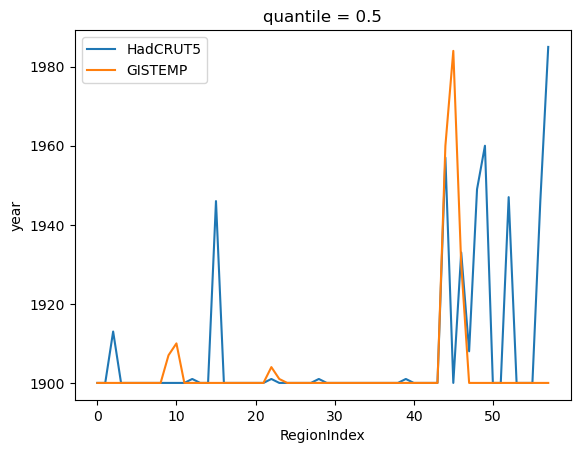

In [51]:
hadcrut5_startyear_final.plot(label="HadCRUT5")
gistemp_startyear_final.plot(label="GISTEMP")

plt.legend()


In [67]:
_temp_mask = _hadcrut5_ds.groupby("time.year").map(annual_data, season_threshold=4)

In [72]:
_temp_mask.sel(RegionIndex=15).sum()

<xarray.DataArray 'season' ()> Size: 8B
array(156)
Coordinates:
    RegionIndex   int64 8B 15
    Continent     <U15 60B 'SOUTH-AMERICA'
    Type          <U10 40B 'Land'
    RegionName    <U25 100B 'S.South-America'
    RegionAbbrev  <U4 16B 'SSA'

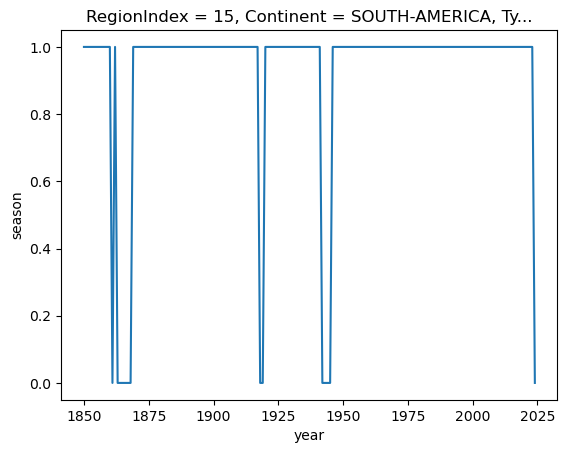

In [63]:
_temp_mask.sel(RegionIndex=15).plot()

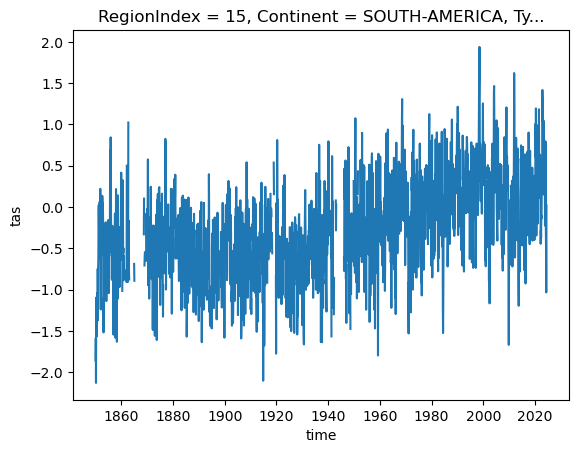

In [55]:
_hadcrut5_ds.sel(RegionIndex=15).plot()

In [53]:
hadcrut5_startyear_final.sel(RegionIndex=15)

<xarray.DataArray 'year' ()> Size: 8B
array(1946.)
Coordinates:
    RegionIndex   int64 8B 15
    Continent     <U15 60B 'SOUTH-AMERICA'
    Type          <U10 40B 'Land'
    RegionName    <U25 100B 'S.South-America'
    RegionAbbrev  <U4 16B 'SSA'
    quantile      float64 8B 0.5

In [19]:
hadcrut5_startyear_conservative

<xarray.DataArray 'year' (RegionIndex: 58)> Size: 464B
array([1899., 1899., 1913., 1853., 1850., 1850., 1870., 1884., 1883.,
       1891., 1894., 1891., 1901., 1873., 1869., 1946., 1899., 1850.,
       1850., 1850., 1889., 1886., 1901., 1898., 1895., 1899., 1892.,
       1881., 1901., 1850., 1862., 1886., 1875., 1875., 1875., 1872.,
       1878., 1875., 1881., 1901., 1879., 1858., 1877., 1879., 1957.,
         nan, 1933., 1908., 1949., 1960., 1874., 1884., 1947., 1876.,
       1876., 1894., 1946., 1985.])
Coordinates:
  * RegionIndex   (RegionIndex) int64 464B 0 1 2 3 4 5 6 ... 52 53 54 55 56 57
    Continent     (RegionIndex) <U15 3kB 'POLAR' 'NORTH-AMERICA' ... 'SOUTHERN'
    Type          (RegionIndex) <U10 2kB 'Land' 'Land' ... 'Ocean' 'Ocean'
    RegionName    (RegionIndex) <U25 6kB 'Greenland/Iceland' ... 'Southern-Oc...
    RegionAbbrev  (RegionIndex) <U4 928B 'GIC' 'NWN' 'NEN' ... 'EIO' 'SIO' 'SOO'

In [20]:
hadcrut5_startyear_conservative - hadcrut5_startyear_optimist

<xarray.DataArray 'year' (RegionIndex: 58)> Size: 464B
array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0., nan,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.])
Coordinates:
  * RegionIndex   (RegionIndex) int64 464B 0 1 2 3 4 5 6 ... 52 53 54 55 56 57
    Continent     (RegionIndex) <U15 3kB 'POLAR' 'NORTH-AMERICA' ... 'SOUTHERN'
    Type          (RegionIndex) <U10 2kB 'Land' 'Land' ... 'Ocean' 'Ocean'
    RegionName    (RegionIndex) <U25 6kB 'Greenland/Iceland' ... 'Southern-Oc...
    RegionAbbrev  (RegionIndex) <U4 928B 'GIC' 'NWN' 'NEN' ... 'EIO' 'SIO' 'SOO'

#### DCENT

In [21]:
dcent_startyear_list = []
for i, _file in enumerate(dcent_unfilled_files):
    print(i, end=" ")

    _dcent_ds = xr.open_dataset(_file)[dcent_unfilled_tas_var]
    
    # Create mask of available by Nathan's GISTEMP standard but 4 seasons.
    # Require 4 seasons because trends may be influenced by missing seasons.
    _availability_mask = _dcent_ds.groupby("time.year").map(annual_data, season_threshold=4)
    _realization_startyears = startyear3(_availability_mask)

    dcent_startyear_list.append(_realization_startyears)

dcent_startyears = xr.concat(dcent_startyear_list, dim="realization")
dcent_startyear_conservative = dcent_startyears.max(dim="realization")
dcent_startyear_optimist = dcent_startyears.min(dim="realization")

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 

Disagreement between

Text(0, 0.5, 'SST Anomaly (deg. C)')

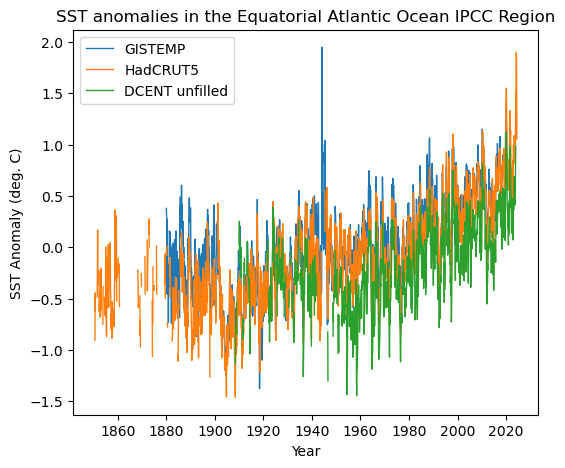

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(6,5))

ax.plot(
    _gistemp_ds["time"],
    _gistemp_ds.sel(RegionIndex=51).squeeze(),
    label="GISTEMP",
    linewidth=1,
)
ax.plot(
    _hadcrut5_ds["time"],
    _hadcrut5_ds.sel(RegionIndex=51).squeeze(),
    label="HadCRUT5",
    linewidth=1,
)
ax.plot(
    _dcent_ds["time"],
    _dcent_ds.sel(RegionIndex=51).squeeze(),
    label="DCENT unfilled",
    linewidth=1,
)

plt.legend()

plt.title("SST anomalies in the Equatorial Atlantic Ocean IPCC Region")

ax.set_xlabel("Year")
ax.set_ylabel("SST Anomaly (deg. C)")

### Process time series into unforced trends as a function of trend duration

Using code from:  

trend_uncertainty/PIC_trend_preproc.ipynb

__Define functions:__

In [6]:
def get_trends_allstartyears(data,duration,startyears,dim='year'):
    '''
    Calculate: 
    a. trends of a given duration
    '''
    
    description = 'Trends for an unforced Pre-Industrial Control simulation sampled by timeseries startyear and duration.'
    
    # Initialize list to save to
    trends_list = []
    
    for i,startyear in enumerate(startyears):
        
        _startyr = startyear
        _endyr   = startyear + duration - 1

        _tsel = data.sel(year=slice(_startyr,_endyr)) # index differently here because the dates are different

        # Calculate the slope
        # print(_tsel)
        # print(dim)
        _tsel_polyfit = _tsel.polyfit(dim=dim, deg=1, skipna=False)['polyfit_coefficients'].sel(degree=1)
        _tsel_slopes  = _tsel_polyfit.drop('degree')
        
        trends_list.append(_tsel_slopes.assign_coords({'startyear':startyear}).expand_dims('startyear'))
        
    out = xr.concat(trends_list,dim='startyear').assign_coords({'duration':duration}).expand_dims('duration')
        
    return out

In [7]:
def compute_trends_wrapper(data,durations=np.arange(5,81,),**kwargs):
    '''
    Wrapper for running 'get_allvar_allstartyears' for different durations.
    Setup with correct startyears and concatenate at the end.
    '''
    
    first_year = data['year'][0]
    last_year  = data['year'][-1]

    trends_allstartyear_allduration_list = []

    for duration in durations:
        print(duration,end=' ')
        _startyears = np.arange(first_year,last_year+2-duration,1)

        allvar_onedur_ds = get_trends_allstartyears(data,
                                                    duration=duration,
                                                    startyears=_startyears,
                                                    **kwargs
                                                   )
        
        trends_allstartyear_allduration_list.append(allvar_onedur_ds)
                
    trends_allstartyear_allduration_ds = xr.concat(trends_allstartyear_allduration_list,dim='duration')
        
    # Add metadata
    trends_allstartyear_allduration_ds = trends_allstartyear_allduration_ds.assign_coords({"RegionName":   ("RegionIndex", data.RegionName)})
    trends_allstartyear_allduration_ds = trends_allstartyear_allduration_ds.assign_coords({"RegionAbbrev": ("RegionIndex", data.RegionAbbrev)})

    trends_allstartyear_allduration_ds.name = 'TAS_trends'
    
    return trends_allstartyear_allduration_ds

### Compute trends for all durations and save

In [8]:
gistemp_tas_var = 'tas'
hadcrut5_tas_var = 'tas'

#### GISTEMP 5x5

In [9]:
test_ds1 = xr.open_dataset(gistemp_5x5_files[0])
test_ds2 = xr.open_dataset(gistemp_5x5_files[1])

In [10]:
test_ds1 = xr.open_dataset(hadcrut5_files[0])
test_ds2 = xr.open_dataset(hadcrut5_files[1])

In [11]:
test_ds2

<xarray.Dataset>
Dimensions:       (RegionIndex: 58, realization: 1, time: 1476)
Coordinates:
  * realization   (realization) int64 1
  * time          (time) datetime64[ns] 1900-01-16T12:00:00 ... 2022-12-16T12...
  * RegionIndex   (RegionIndex) int64 0 1 2 3 4 5 6 7 ... 51 52 53 54 55 56 57
    RegionAbbrev  (RegionIndex) object ...
    RegionName    (RegionIndex) object ...
Data variables:
    tas           (realization, time, RegionIndex) float64 ...

In [12]:
test_ds1

<xarray.Dataset>
Dimensions:      (duration: 119, latitude: 36, longitude: 72, realization: 1)
Coordinates:
    startyear    int64 ...
  * longitude    (longitude) float64 -177.5 -172.5 -167.5 ... 167.5 172.5 177.5
  * latitude     (latitude) float64 -87.5 -82.5 -77.5 -72.5 ... 77.5 82.5 87.5
  * duration     (duration) int64 3 4 5 6 7 8 9 ... 115 116 117 118 119 120 121
  * realization  (realization) int64 1
Data variables:
    tas          (duration, latitude, longitude, realization) float64 ...

In [13]:
gistemp_5x5_ds = xr.open_mfdataset(gistemp_5x5_files,chunks={'RegionIndex':1})

In [14]:
%%time
gistemp_filelist = []
for _file in gistemp_5x5_files:
    _gistemp_ds = xr.open_dataset(_file)
    _gistemp_annual = _gistemp_ds[gistemp_tas_var].groupby('time.year').mean('time')

    gistemp_filelist.append(_gistemp_annual)

gistemp_annual = xr.concat(gistemp_filelist, dim="realization")

CPU times: user 12.9 s, sys: 239 ms, total: 13.1 s
Wall time: 13.9 s


In [15]:
%%time

gistemp_trends_all = compute_trends_wrapper(gistemp_annual,durations=np.arange(3,122,1))

3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 CPU times: user 1min 4s, sys: 3.33 s, total: 1min 7s
Wall time: 1min 13s


In [17]:
gistemp_trends_all.to_netcdf('%s/%s/ensembleChunks_0001_0200.trends.190001-202012.nc' % (obslens_tseries_dir,'GISTEMP_5x5/20240820/'))

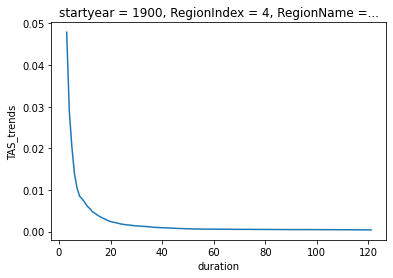

In [18]:
gistemp_trends_all.sel(RegionIndex=4, startyear=1900).sortby("realization").std("realization").plot()

In [19]:
del gistemp_5x5_ds,gistemp_annual,gistemp_trends_all

#### HadCRUT5

In [24]:
%%time
hadcrut5_filelist = []
for _file in hadcrut5_files:
    # print(_file)
    _hadcrut5_ds = xr.open_dataset(_file)
    _hadcrut5_annual = _hadcrut5_ds[hadcrut5_tas_var].groupby('time.year').mean('time')

    hadcrut5_filelist.append(_hadcrut5_annual)

hadcrut5_annual = xr.concat(hadcrut5_filelist, dim="realization")

/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/

CPU times: user 13.6 s, sys: 181 ms, total: 13.8 s
Wall time: 20.7 s


In [28]:
%%time

hadcrut5_trends_all = compute_trends_wrapper(hadcrut5_annual,durations=np.arange(3,122,1))

3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 CPU times: user 1min 7s, sys: 1.09 s, total: 1min 8s
Wall time: 1min 13s


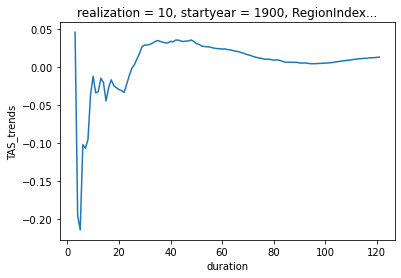

In [29]:
hadcrut5_trends_all.sel(startyear=1900,RegionIndex=0, realization=10).plot()

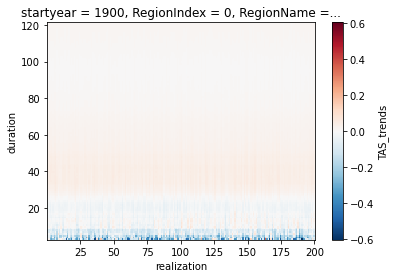

In [30]:
hadcrut5_trends_all.sel(startyear=1900,RegionIndex=0,).sortby("realization").plot()

#### Interesting behavior in the observational uncertainty curve in Central North America when starting the record at 1900.

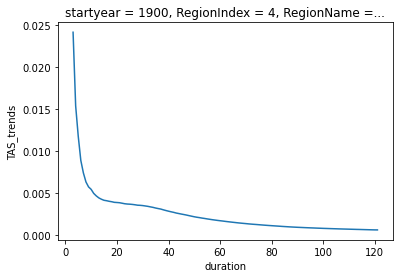

In [31]:
hadcrut5_trends_all.sel(RegionIndex=4, startyear=1900).sortby("realization").std("realization").plot()

In [32]:
hadcrut5_trends_all.to_netcdf('%s/%s/HadCRUT.5.0.2.0_1_200.trends.190001-202212.nc' % (obslens_tseries_dir,'HadCRUT5/20240820/'))

In [33]:
del hadcrut5_annual,hadcrut5_trends_all